# labeling MNIST data with a convolutional neural network



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

TensorFlow version: 2.10.0
Keras version: 2.10.0


In [3]:
print(tf.__file__)
print(tf.keras.__file__)

c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\tensorflow\__init__.py
c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\keras\api\_v2\keras\__init__.py


In [4]:
# first, we load the data:

data = pd.read_csv('mnist_train_small.csv', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Data preparation:

Now, the first column are the labels, the remaining 784 columns are the pixel values. I have to:

1) split the data in train and validation sets

2) split validation sets into features and labels

3) correctly format features intoa a 28x28 grid

In [5]:
def data_prep(input_df,split=0.3,verbose=False):
    rng = np.random.default_rng(seed=123)
    data=np.array(input_df)
    m,n=data.shape
    rng.shuffle(data)
    train_size=int(m*split)
    x_val=data[:train_size,1:]#the last 784 columns of the first train_size rows are the training features
    y_val=data[:train_size,0]
    x_train=data[train_size:,1:]
    y_train=data[train_size:,0]
    x_train=(x_train.reshape(-1,28,28)/255.).astype('float32')
    x_val=(x_val.reshape(-1,28,28)/255.).astype('float32')
    if verbose:
        print(x_train.shape)
    y_train = tf.keras.utils.to_categorical(y_train)
    y_val = tf.keras.utils.to_categorical(y_val)
    return x_train,y_train,x_val,y_val

In [6]:
x_train, y_train, x_val, y_val= data_prep(data, verbose=True)

(14000, 28, 28)


In [7]:
#x_train = tf.expand_dims(x_train, axis=-1)
#x_val = tf.expand_dims(x_val, axis=-1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

#### Now I have the data prepared, I can construct a CNN and feed data to it:

In [8]:
def create_model():
    '''simple convolutional neural network'''
    model=tf.keras.models.Sequential(name='CNN_MNIST')
    model.add(tf.keras.layers.Conv2D(10,4,strides=(1,1), activation='relu',input_shape=(28,28,1,),name='Conv1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(10,2,activation='relu',))
    print(model.output_shape)
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=100,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=100,activation='relu'))
    model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.output_shape)
    return model

In [9]:
def visualize_example(x,y,index):
    #img=np.reshape(x[index],(28,28))
    img=x[index]*255.
    label=np.argmax(y[index])
    print('Example number: ', index, '\nLabel: ' , label)
    plt.gray()
    plt.imshow(img, interpolation='nearest')
    plt.show()


In [10]:
def test_model(model,x,y,ind,show_probability=False):
    example=x[None,ind]
    if show_probability:
        print(model(example))
    prediction=np.argmax(model.predict(example))
    print('Prediction: ', prediction)
    visualize_example(x,y,ind)


In [11]:
model=create_model()
print(model.summary())

(None, 11, 11, 10)
(None, 10)
Model: "CNN_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 25, 25, 10)        170       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 10)        410       
                                                                 
 dropout (Dropout)           (None, 11, 11, 10)        0         
                                                                 
 flatten (Flatten)           (None, 1210)              0         
                                                                 
 dense (Dense)               (None, 100)               121100    
                           

In [12]:
x_train.shape

(14000, 28, 28, 1)

In [13]:
history = model.fit(x_train, y_train,batch_size=30, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
467/467 [==============================] - 9s 9ms/step - loss: 0.5055 - accuracy: 0.8471 - val_loss: 0.1799 - val_accuracy: 0.9443
Epoch 2/10
467/467 [==============================] - 4s 9ms/step - loss: 0.1747 - accuracy: 0.9476 - val_loss: 0.1262 - val_accuracy: 0.9588
Epoch 3/10
467/467 [==============================] - 5s 11ms/step - loss: 0.1195 - accuracy: 0.9629 - val_loss: 0.0949 - val_accuracy: 0.9703
Epoch 4/10
467/467 [==============================] - 4s 9ms/step - loss: 0.0928 - accuracy: 0.9694 - val_loss: 0.0885 - val_accuracy: 0.9718
Epoch 5/10
467/467 [==============================] - 4s 9ms/step - loss: 0.0804 - accuracy: 0.9726 - val_loss: 0.0769 - val_accuracy: 0.9765
Epoch 6/10
467/467 [==============================] - 4s 9ms/step - loss: 0.0652 - accuracy: 0.9788 - val_loss: 0.0764 - val_accuracy: 0.9755
Epoch 7/10
467/467 [==============================] - 5s 10ms/step - loss: 0.0532 - accuracy: 0.9829 - val_loss: 0.0777 - val_accuracy: 0.9773
Epoc

In [14]:
model.predict(x_train[None,np.random.randint(0,4000)])

1/1 [==============================] - 0s 194ms/step


array([[2.2663869e-10, 6.6601700e-08, 7.7939532e-13, 4.9841331e-10,
        1.9723612e-09, 9.9999475e-01, 3.4493954e-09, 1.0763741e-10,
        1.8011227e-07, 4.9525115e-06]], dtype=float32)

tf.Tensor(
[[4.7646069e-09 3.8239296e-09 2.0290530e-10 5.5787512e-03 5.5884540e-11
  9.9440938e-01 1.9184399e-06 4.0531511e-09 2.6320012e-07 9.6432796e-06]], shape=(1, 10), dtype=float32)
1/1 [==============================] - 0s 25ms/step
Prediction:  5
Example number:  1902 
Label:  5


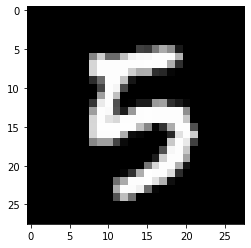

In [15]:
test_model(model,x_val,y_val,np.random.randint(0,4000),show_probability=True)

In [16]:
# Save the trained model
savemodel=False
modelFileName = 'models/mnistNNv1.h5'
if savemodel:
    model.save(modelFileName)
    #del model  # deletes the existing model variable
    print('model saved as', modelFileName)

Next: obtain confusion matrix

In [17]:
model = tf.keras.models.load_model(modelFileName)


c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


188/188 [==============================] - 1s 3ms/step


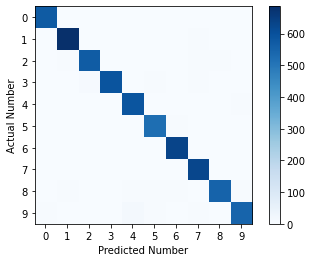

              precision    recall  f1-score   support

           0      0.979     0.993     0.986       576
           1      0.980     0.993     0.986       691
           2      0.986     0.978     0.982       583
           3      0.995     0.967     0.981       612
           4      0.967     0.987     0.977       597
           5      0.981     0.985     0.983       529
           6      0.981     0.997     0.989       633
           7      0.977     0.989     0.983       634
           8      0.986     0.963     0.974       573
           9      0.980     0.956     0.968       572

    accuracy                          0.981      6000
   macro avg      0.981     0.981     0.981      6000
weighted avg      0.981     0.981     0.981      6000



In [19]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
#import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#import matplotlib.pyplot as plt
%matplotlib inline


class_probabilities = model.predict(x_val)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_val,axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks, rotation=0)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Number")
plt.ylabel("Actual Number")
plt.show()
#print(cm)
print(classification_report(true_labels,predictions,digits=3))